# Análisis de la estructura de los residuos

En esta libreta vamos a analizar la estructura de los residuos de dos modelos "gemelos" de random forest sobre 2 variables objetivo: Precio total (PRICE) y Precio medio por superficie (UNITPRICE).

Tomaría como entrada los ficheros de errores generados por el modelo, principalmente vamos a estudiar la idoneidad del $R^2$ como única medida para evaluar la calidad del ajuste, y segundo veremos si son medidas "absolutas" que pueden usarse para comparar modelos entre si (cuando la variable objetivo maneja una dimensión diferente o se le aplicación una transformación no lineal).

In [162]:
import sys
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv() # Load the environment variables from .env file

import importlib
# Añadir la ruta al directorio src para importar módulos personalizados
sys.path.append("../src")

# Unload the module if already loaded
import idealista18.loader as loader
import idealista18.enricher as enricher
import idealista18.util as util
import pandas as pd
import numpy as np

# Datos y funciones de utilidad

Vamos a analizar las distribuciones de los cuadrados de la variable objetivo, y de los errores de los modelos para 2 targets: UNITPRICE y PRICE

Usaremos unos cuantos datos básicos de una configuración de modelo de árboles con Random Forests, con una configuración de base:

* 100 estimadores
* 10 profundidad
* el resto de parámetros son valores por defecto de la implementación de RF de scikitlearn

Construiremos una función para el cálculo de métricas

In [163]:
def metrics_per_group(subdf, target_name):
    y_true = subdf['actual'].values
    y_pred = subdf['predicted'].values
    error = y_true - y_pred
    abs_error = np.abs(error)
    # Avoid division by zero in percentage metrics
    with np.errstate(divide='ignore', invalid='ignore'):
        perc_error = np.where(y_true != 0, abs_error / np.abs(y_true), np.nan)  # absolute percentage error

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else float('nan')
    mae = np.mean(abs_error)
    medae = np.median(abs_error)
    mape = np.nanmean(perc_error) * 100  # In percent
    medape = np.nanmedian(perc_error) * 100  # In percent

    # Variances (for completeness)
    var_actual = np.var(y_true, ddof=1)
    var_pred = np.var(y_pred, ddof=1)
    var_error = np.var(error, ddof=1)
    
    return pd.Series({
        'target': target_name,
        'var_actual': var_actual,
        'var_predicted': var_pred,
        'var_error': var_error,
        'r2': r2,
        'mae': mae,
        'medae': medae,
        'mape': mape,
        'medape': medape
    })

Y vemos los datos que hemos guardado de nuestros experimentos

In [164]:
TARGET = 'PRICE'
f_name = f"./data/idealista18_madrid_randomforest_{TARGET}_estimators-100_depth-10.csv.gz"

df = pd.read_csv(f_name)
df.head()

,dataset,actual,predicted
0,train,152000,163271.785771
1,train,656000,843830.358486
2,train,162000,168064.345788
3,train,630000,612673.862705
4,train,629000,786745.042369


# Cálculo de métricas PRICE

Hacemos un análisis con los precios, observamos el alto valor del $R^2$, los mape y medape están en los rangos esperados

In [165]:
import pandas as pd
import numpy as np

TARGET = 'PRICE'
f_name = f"./data/idealista18_madrid_randomforest_{TARGET}_estimators-100_depth-10.csv.gz"

df = pd.read_csv(f_name)

# Create the required DataFrame
df_eval_price = df[['dataset', 'actual', 'predicted']].copy()
df_eval_price['error'] = df_eval_price['actual'] - df_eval_price['predicted']

# Group by dataset and calculate all metrics
metrics_summary_price = df_eval_price.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()

# Show as a table
print(metrics_summary_price)


  dataset target    var_actual  var_predicted     var_error        r2  \
0    test  PRICE  1.743077e+11   1.591227e+11  1.441727e+10  0.917278   
1   train  PRICE  1.697394e+11   1.534835e+11  8.173677e+09  0.951846   

            mae         medae       mape     medape  
0  61163.050594  32849.768717  17.855311  12.714837  
1  53995.618054  31251.124110  16.759831  11.811925  


/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/2840770113.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_summary_price = df_eval_price.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()


# Cálculo de métricas UNITPRICE

Hacemos el análisis análogo para precio por metro cuadrado, curiosamente observamos un sensible descenso de los errores medios y medianos, aunque el $R^2$ es menor.

In [166]:
import pandas as pd
import numpy as np

TARGET = 'UNITPRICE'
f_name = f"./data/idealista18_madrid_randomforest_{TARGET}_estimators-100_depth-10.csv.gz"

df = pd.read_csv(f_name)

# Create the required DataFrame
df_eval_unitprice = df[['dataset', 'actual', 'predicted']].copy()
df_eval_unitprice['error'] = df_eval_unitprice['actual'] - df_eval_unitprice['predicted']

# Group by dataset and calculate all metrics
metrics_summary_unitprice = df_eval_unitprice.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()

# Show as a table
print(metrics_summary_unitprice)

  dataset     target    var_actual  var_predicted      var_error        r2  \
0    test  UNITPRICE  2.918055e+06   2.217041e+06  618627.180979  0.787995   
1   train  UNITPRICE  2.938256e+06   2.220674e+06  542703.981699  0.815297   

          mae       medae       mape     medape  
0  543.343041  373.332852  16.481064  11.843827  
1  512.946944  355.234675  15.534184  11.116373  


/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/1042860463.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_summary_unitprice = df_eval_unitprice.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()


# Análisis de las distribuciones

Mostramos la distribución de los errores, temas que se pueden observar:

* El rango de las predicciones es menor (el modelo suaviza los extremos)
* Predice bien los rangos más bajos (hasta 2500) pero entre 2500K y 6000K ya hay más problemas
* El control con la superficie aflora la "multimodalidad" de la distribución: una con mediana en 2K y otra con mediana en 4K (ambas con una cola hacia la izquierda)

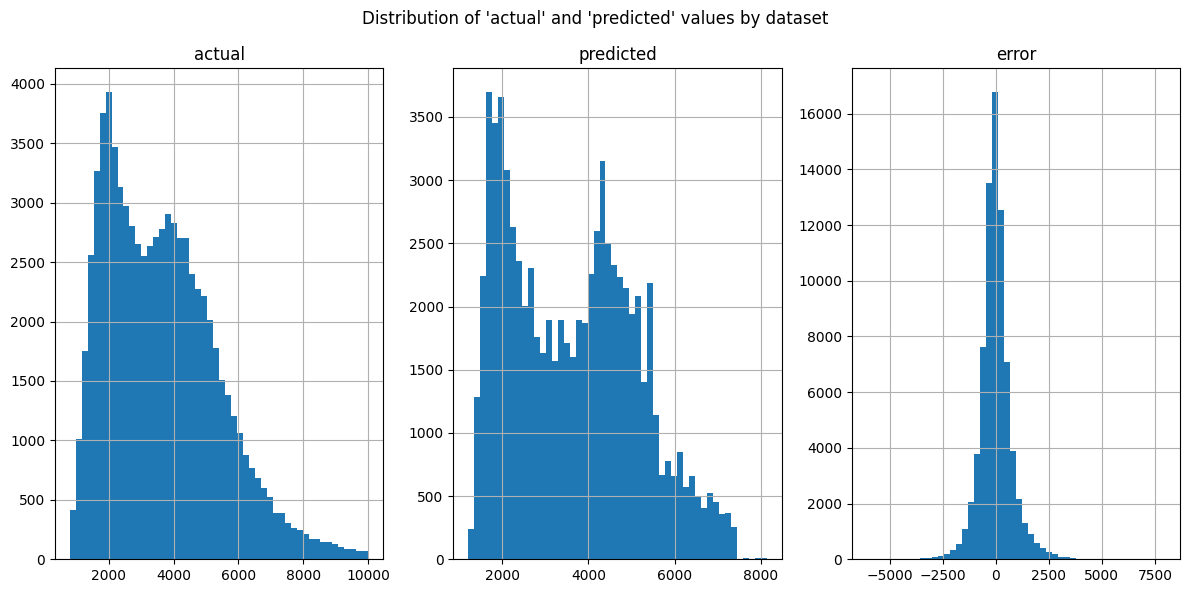

In [167]:
import matplotlib.pyplot as plt

# Plot histograms for each numeric column in df
df_eval_unitprice.hist(bins=50, figsize=(12, 6), layout=(1, 3))
plt.suptitle("Distribution of 'actual' and 'predicted' values by dataset")
plt.tight_layout()
#plt.title('Distribución de valores de precios por metro cuadrado (real, predicho y error)')
plt.show()

Sin embargo cuando analizamos el precio total las gráficas muestran un rango de dispersión enorme

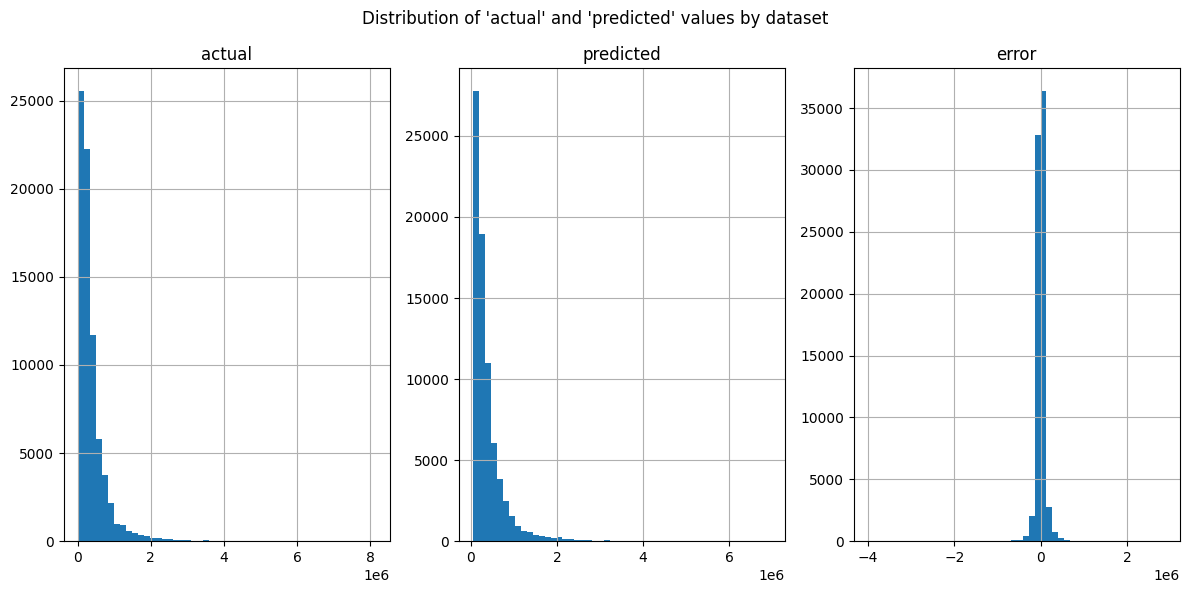

In [168]:
import matplotlib.pyplot as plt

# Plot histograms for each numeric column in df
df_eval_price.hist(bins=50, figsize=(12, 6), layout=(1, 3))
plt.suptitle("Distribution of 'actual' and 'predicted' values by dataset")
plt.tight_layout()
plt.show()

In [169]:
metrics_all = pd.concat([metrics_summary_price, metrics_summary_unitprice], ignore_index=True)
metrics_all.T

,0,1,2,3
dataset,test,train,test,train
target,PRICE,PRICE,UNITPRICE,UNITPRICE
var_actual,174307669854.572357,169739398656.05014,2918055.016546,2938256.12872
var_predicted,159122673378.022491,153483471818.704742,2217041.387378,2220673.700633
var_error,14417270464.927746,8173677013.744987,618627.180979,542703.981699
r2,0.917278,0.951846,0.787995,0.815297
mae,61163.050594,53995.618054,543.343041,512.946944
medae,32849.768717,31251.12411,373.332852,355.234675
mape,17.855311,16.759831,16.481064,15.534184
medape,12.714837,11.811925,11.843827,11.116373


# Prueba de eliminación de outliers

Es posible que los valores más extremos distorsionen la medida del $R^2$. Hacemos una prueba eliminando los valores más extremos de la muestra, eliminamos aquellos registros que estén por encima de los percentiles 95 del error y del precio 

In [ ]:
TARGET = 'PRICE'

# Calculate thresholds for top 5% of absolute errors and actual values
error_threshold = df_eval_price['error'].abs().quantile(0.95)
actual_threshold = df_eval_price['actual'].quantile(0.95)

# Filter out rows where either error or actual is in the top 5%
df_eval_price_cut = df_eval_price[
    (df_eval_price['error'].abs() <= error_threshold) &
    (df_eval_price['actual'] <= actual_threshold)
].copy()

# Group by dataset and calculate all metrics
metrics_summary_price_cut = df_eval_price_cut.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()

# Show as a table
print(metrics_summary_price_cut)

  dataset target    var_actual  var_predicted     var_error        r2  \
0    test  PRICE  4.167059e+10   4.082533e+10  3.160551e+09  0.923673   
1   train  PRICE  4.405323e+10   4.269649e+10  2.987231e+09  0.931768   

            mae         medae       mape     medape  
0  41401.978685  29488.081360  16.481347  12.212958  
1  40122.223824  28532.850143  15.926275  11.552320  


/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/462326523.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_summary_price_cut = df_eval_price_cut.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()


Es más difícil identificar varias poblaciones, hay un indicio de que existe uno con media cerca de 200K, otra con media en 350K (aproximadamente) y otra en 600K.

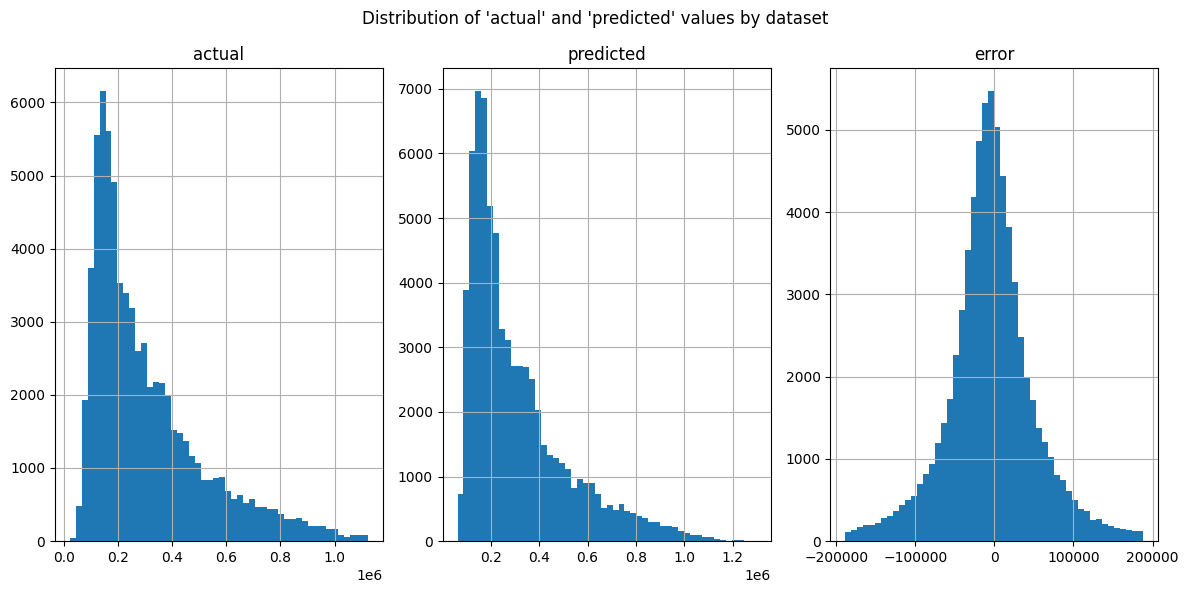

In [171]:
import matplotlib.pyplot as plt

# Plot histograms for each numeric column in df
df_eval_price_cut.hist(bins=50, figsize=(12, 6), layout=(1, 3))
plt.suptitle("Distribution of 'actual' and 'predicted' values by dataset")
plt.tight_layout()
plt.show()

Vamos a evaluar que la medida es estadísticamente representativa, para ello hacemos un remuestreo de 50 muestras sobre muestras aleatorias del 25% de nuestros conjuntos de datos, por lo que se puede ver el resultado del corte 80%-20% es consistente con esta medida

In [172]:
TARGET = 'PRICE'

metrics_summary_price_sample_results = []
for i in range(0,50):
    # Filter out rows where either error or actual is in the top 1%
    df_eval_price_sample = df_eval_price.sample(frac=0.25, random_state=42)
    # Group by dataset and calculate all metrics
    results = df_eval_price_sample.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()
    metrics_summary_price_sample_results.append(results)

metrics_summary_price_sample_results = pd.concat(metrics_summary_price_sample_results)
metrics_summary_unitprice = metrics_summary_price_sample_results.groupby('dataset').agg('mean', ['r2', 'mae'])
metrics_summary_unitprice

/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/2615575028.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_eval_price_sample.groupby('dataset').apply(metrics_per_group, TARGET).reset_index()
/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/2615575028.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_eval_price_sample.groupby('dataset').apply(m

,var_actual,var_predicted,var_error,r2,mae,medae,mape,medape
dataset,,,,,,,,
test,1.550547e+11,1.411726e+11,1.306765e+10,0.915690,58858.703358,32976.194750,17.982873,12.921262
train,1.674086e+11,1.509710e+11,8.209996e+09,0.950955,53945.320850,31072.463756,16.646490,11.830886


No parece que los valores más extremos estén causando una distorsion en el $R2$, todo parece indicar que se trata de otra propiedad del estadistico de estudio 

¿Qué sucede?, la relación entre la distribución de los errores y el target no son comparables. ¿Cuáles podrían ser los motivos?:

* El R2 mide la relación entre dos varianzas la de los residuos y la de la variable target. En particular es 1 - var(error) / var(target). 
* La variable predicha ofrece valores menos extremos que la variable original, podemos decir que se trata de un valor acotado por arriba y por abajo.
* La varianza es una variable extremadamente sentible a valores extremos, esto puede conducir a que var(target) ofrezca valores muy altos -> cuando este valor tiende a "infinito" el segundo término es prácticamente cero, por tanto R2 => 1 cuando var(target) es muy grande.
* La variable precio unitario (UNITPRICE) es una transformación no lineal del precio total, y "controlada" los valores por la superficie por tanto la variabilidad de la variable target tiene un rango menor.
* Un aspecto importante es que para que el $R2$ no sea homogéneo introduce un mayor nivel de dificultad a la hora de interpretar sus resultados.

## ¿Posibles soluciones?

Podríamos intentar usar medidas estadísticas robustas de cara a mitigar estos efectos, una idea es construir un "pseudo $R^2$ que sirviera este propósito. Tomamos una medida de centralidad no expuesta a valores extreemos como la mediana, y la aplicamos 

$$
    pseudo\ R^2 = 1 - \frac{median([y - \hat{y}]^2)}{median({[y - median(y)]^2})}
$$

Donde $y$ es el valor de la variable objetivo y $\hat{y}$ el valor predicho.

Adaptamos nuestra función de cálculo de métricas a tal efecto


In [173]:
#
#   Intentamos controlar la variabilidad de la variable objetiva y del error
#   para evitar que los resultados se vean afectados por valores atípicos
#   
#   Construimos un pseudo R2 basado en medianas y medianas de errores
#
#   pseudo R2 = 1 - (mediana de errores al cuadrado / mediana de la varianza de la variable objetivo)
#
def robust_metrics_per_group(subdf, target_name):
    y_true = subdf['actual'].values
    y_pred = subdf['predicted'].values
    error = y_true - y_pred
    abs_error = np.abs(error)
    # Avoid division by zero in percentage metrics
    with np.errstate(divide='ignore', invalid='ignore'):
        perc_error = np.where(y_true != 0, abs_error / np.abs(y_true), np.nan)  # absolute percentage error

    ss_res_median = np.median((y_true - y_pred) ** 2)
    ss_tot_median = np.median((y_true - np.median(y_true)) ** 2)
    r2 = 1 - ss_res_median / ss_tot_median if ss_tot_median != 0 else float('nan')
    mae = np.mean(abs_error)
    medae = np.median(abs_error)
    mape = np.nanmean(perc_error) * 100  # In percent
    medape = np.nanmedian(perc_error) * 100  # In percent

    # Variances (for completeness)
    var_actual = np.var(y_true, ddof=1)
    var_pred = np.var(y_pred, ddof=1)
    var_error = np.var(error, ddof=1)
    
    return pd.Series({
        'target': target_name,
        'var_actual': var_actual,
        'var_predicted': var_pred,
        'var_error': var_error,
        'r2': r2,
        'mae': mae,
        'medae': medae,
        'mape': mape,
        'medape': medape
    })

Calculamos los valores para la variable __PRICE__

In [174]:
metrics_summary_price_alter = df_eval_price.\
    groupby('dataset').\
        apply(robust_metrics_per_group, 'PRICE').\
            reset_index()

# Show as a table
print(metrics_summary_price_alter)

  dataset target    var_actual  var_predicted     var_error        r2  \
0    test  PRICE  1.743077e+11   1.591227e+11  1.441727e+10  0.922500   
1   train  PRICE  1.697394e+11   1.534835e+11  8.173677e+09  0.933295   

            mae         medae       mape     medape  
0  61163.050594  32849.768717  17.855311  12.714837  
1  53995.618054  31251.124110  16.759831  11.811925  


/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/1414872007.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(robust_metrics_per_group, 'PRICE').\


Ahora lo hacemos para el precio unitario

In [175]:
# Group by dataset and calculate all metrics
metrics_summary_unitprice_alter = df_eval_unitprice.\
    groupby('dataset').\
        apply(robust_metrics_per_group, 'UNITPRICE').\
            reset_index()
# Show as a table
print(metrics_summary_unitprice_alter)

  dataset     target    var_actual  var_predicted      var_error        r2  \
0    test  UNITPRICE  2.918055e+06   2.217041e+06  618627.180979  0.911616   
1   train  UNITPRICE  2.938256e+06   2.220674e+06  542703.981699  0.920418   

          mae       medae       mape     medape  
0  543.343041  373.332852  16.481064  11.843827  
1  512.946944  355.234675  15.534184  11.116373  


/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_19676/4012104969.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(robust_metrics_per_group, 'UNITPRICE').\


# Conclusiones

El uso de medidas robustas en el cálculo del $R^2$ parece mitigar la diferencia entre las medidas, no obstante observamos:

* Mayor capacidad de generalización (ligeramente) si el target es UNITPRICE (- overfit)
* Menores errores promedio en UNITPRICE

